---
title: TEM Simulation
authors: [gvarnavides]
date: 2025-06-11
---

This notebook shows how to use abTEM to simulate HRTEM wavefunctions of Si$_3$N$_4$.

In [1]:
import abtem
import ase
import numpy as np
import matplotlib.pyplot as plt

## Build atomic model - Si$_3$N$_4$

We'll use the atomic simulation environment (`ase`) package to build our unit-cell by providing:
- atomic positions of all our atoms in Cartesian coordinates
- unit-cell lengths ($a,b,c$) and angles ($\alpha, \beta, \gamma$) as a six-element list

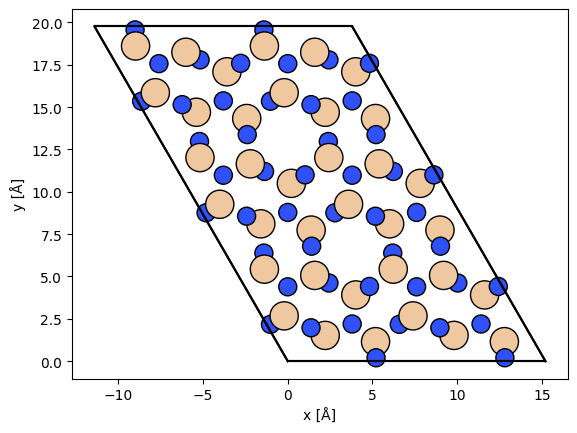

In [41]:
structure = ase.Atoms(
    "Si6N8",
    scaled_positions=[
        (0.82495, 0.59387, 0.75),
        (0.23108, 0.82495, 0.25),
        (0.59387, 0.76892, 0.25),
        (0.40614, 0.23108, 0.75),
        (0.76892, 0.17505, 0.75),
        (0.17505, 0.40613, 0.25),
        
        (0.66667, 0.33334, 0.75),
        (0.33334, 0.66667, 0.25),
        (0.66986, 0.70066, 0.75),
        (0.96920, 0.66986, 0.25),
        (0.70066, 0.03081, 0.25),
        (0.29934, 0.96919, 0.75),
        (0.33015, 0.29934, 0.25),
        (0.03081, 0.33014, 0.75),
    ],
    cell=[7.6045, 7.6045, 2.9052, 90, 90, 120],
    pbc=True
)

abtem.show_atoms(structure * (2,3,1), plane='xy');

The Si$_3$N$_4$ cell we have defined is hexagonal.  The multislice algorithm requires an orthongonal input cell.  
We can tile this unit cell twice to form an orthogonal cell.  abTEM automates this process with the  `orthogonalize_cell` function.

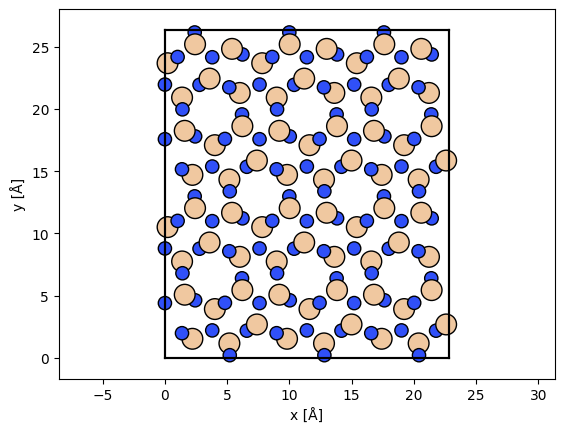

In [42]:
structure_orthogonal = abtem.orthogonalize_cell(structure)
abtem.show_atoms(structure_orthogonal * (3,2,1), plane='xy');

## Calculate projected potentials

We will calculate 8 frozen phonon configurations, using the (3,2,17) tiling of our orthogonal unit cell. This ensures the cell size in-plane is larger than 20x20 Angstroms, which is usually a safe size to prevent wraparound errors due to periodicity. We choose the tiling along the beam direction to be
17 unit cells, giving a total thickness of 2.9052*17 = 49.4 Angstroms, i.e. about 5 nanometers.

In [50]:
frozen_phonons = abtem.FrozenPhonons(
    structure_orthogonal * (3,2,17),
    8,
    {'Si' : 0.05, 'N' : 0.05},
    seed=1,
)

Next, let's calculate the atomic potentials corresponding to each of these frozen phonon configurations. We will use a pixel size sampling of 0.1 Angstroms, a slice thickness of 2 Angstroms, and the Kirkland potentials.

In [51]:
potential = abtem.Potential(
    frozen_phonons,
    sampling = 0.1,
    slice_thickness = 2.0,
    projection = 'infinite',
    parametrization = 'kirkland',
).build(
    lazy=False
)

Let's check the array size of our potential:

In [52]:
potential.shape

(8, 25, 229, 264)

This is storing pre-computed arrays of atomic potentials with in-plane dimensions 229x264 pixels, for each of 25 z-slices, for each of our 8 frozen-phonon configurations.

Let's plot the mean-projected potential for all our frozen-phonon configurations along the slice-direction:

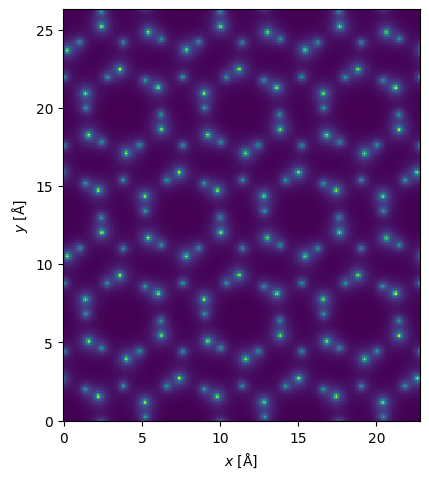

In [53]:
potential.project().show(cmap='viridis');

## HRTEM plane wave multislice simulation

We first initialize a plane wave with an accelerating voltage of 300kV, and then use the multislice algorithm to propagate it through each projected potential slice.

In [54]:
wave = abtem.PlaneWave(energy=300e3)
exit_waves = wave.multislice(potential,lazy=False)

Let's check the size of the output - we should have 8 exit waves, one for each of our frozen phonon configurations.

In [55]:
exit_waves.array.shape

(8, 229, 264)

Plot the exit wave intensities for a single frozen phonon configuration, and the mean of all configurations


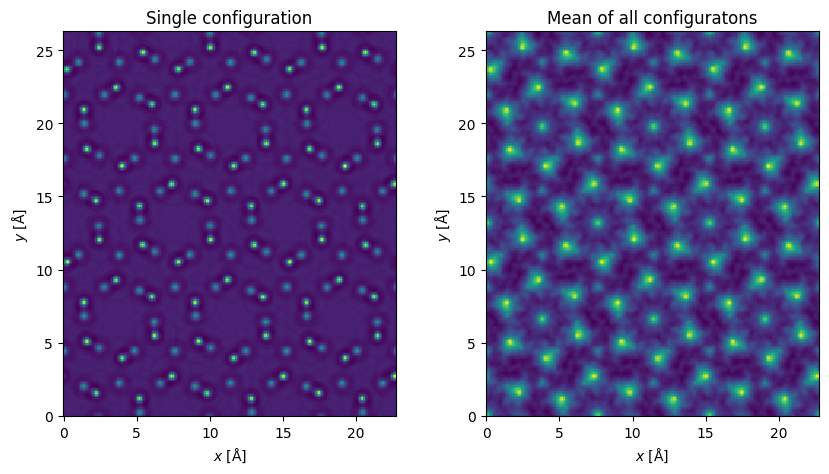

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
exit_waves.show(ax = ax[0],cmap='viridis')
ax[0].set_title('Single configuration');
exit_waves.intensity().mean(0).show(ax = ax[1],cmap='viridis')
ax[1].set_title('Mean of all configuratons');

## Contrast transfer functions

define a CTF - note the units must always be in Angstroms!


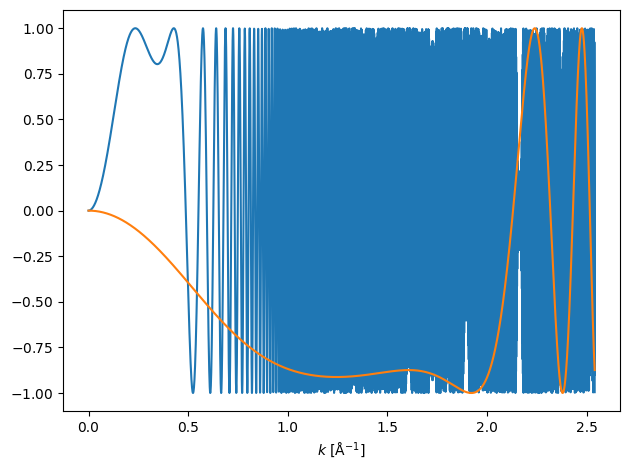

In [57]:
# # # No aberration correction
parameters = {
    'C10': -600,
    'C30': 1.3e7,  # 1.3 mm
    'C50': 5e7,    # 5mm
}

ctf = abtem.CTF(
    energy=300e3,
    aberration_coefficients=parameters,
)

# # Aberration corrected, negative Cs imaging
parameters_corrected = {
    'C10': 30,
    'C30': -8e4,
    'C50': 5e7,
}

ctf_corrected = abtem.CTF(
    energy=300e3,
    aberration_coefficients=parameters_corrected,
)

fig, ax = plt.subplots()

# plot the CTFs
ctf.profiles(gpts=5000).show(ax=ax)
ctf_corrected.profiles(gpts=5000).show(ax=ax)
fig.tight_layout()

In [58]:
abtem.transfer.scherzer_defocus(
    energy = 300e3,
    Cs = 1.3e7,
)

619.6015118652386

plot the image intensity after applying this CTF

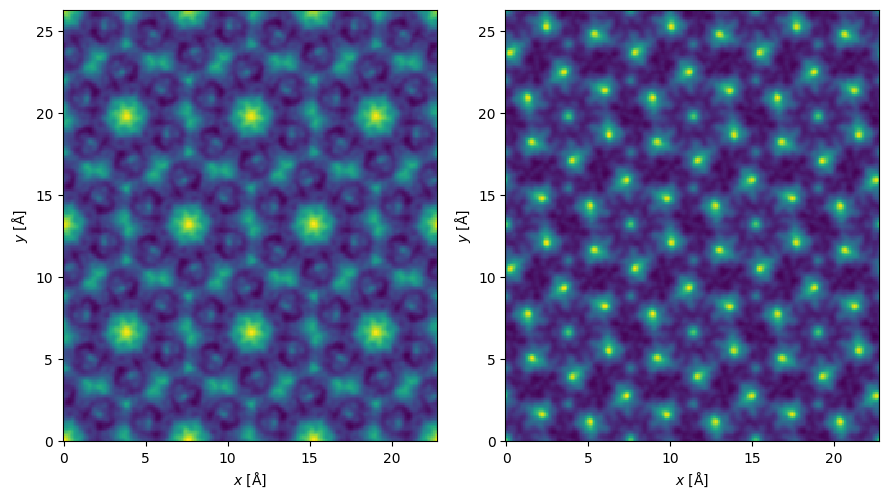

In [59]:
image_wave = exit_waves.apply_ctf(ctf)
image_wave_corrected = exit_waves.apply_ctf(ctf_corrected)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,5))

image_wave.intensity().mean(0).show(
    cmap='viridis',
    ax=ax1
)

image_wave_corrected.intensity().mean(0).show(
    cmap='viridis',
    ax=ax2
)

fig.tight_layout();

Now you see why we like aberration correction!

Let's see what happens when we apply aberrations which are not radially symmetric.

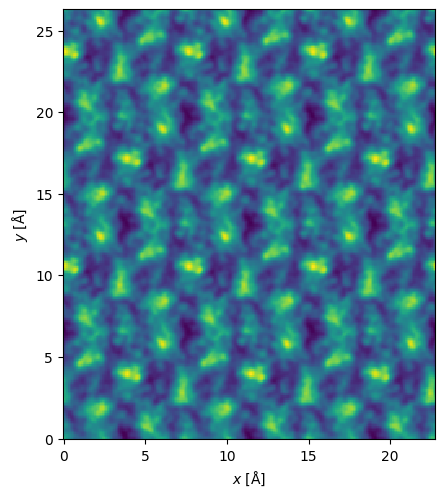

In [62]:
# # Aberration corrected, negative Cs imaging
parameters_asymmetric = {
    'C10': 0,
    'C12': 100,
    'phi12': np.deg2rad(0),
    'C23': 5000,
    'phi23': np.deg2rad(140),
}

ctf_asymmetric = abtem.CTF(
    energy=300e3,
    aberration_coefficients=parameters_asymmetric,
)

# plot the image intensity after applying this CTF
image_wave_asymmetric = exit_waves.apply_ctf(ctf_asymmetric)
image_wave_asymmetric.intensity().mean(0).show(
    figsize=(4.5,5),
    cmap='viridis',
);

## Noise

Why don't we always use zero defocus?  The reason is that we need contrast. The zero defocus plane is approximately in the center of the sample, so we apply a negative defocus to properly center the defocus. We will also apply partial coherence to the waves.

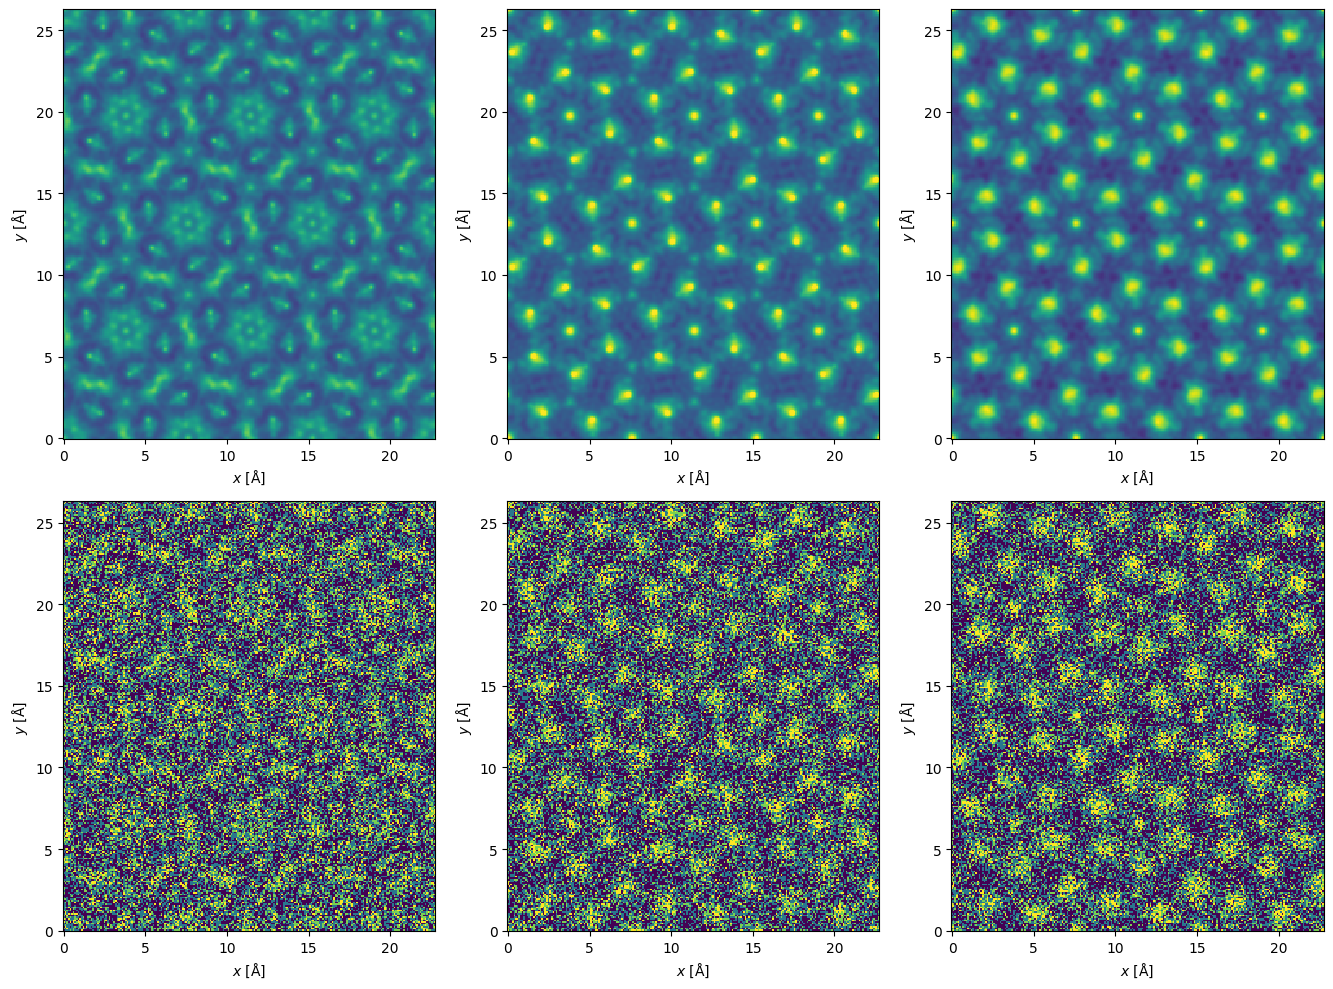

In [64]:
dose = 100
C1_values = [-200, -50, 50]

ctfs = [abtem.CTF(energy=300e3,C10 = C1) for C1 in C1_values]
intensities = [exit_waves.apply_ctf(ctf).intensity().mean(0) for ctf in ctfs]
noisy_intensities = [intensity.poisson_noise(dose) for intensity in intensities]

fig, axs = plt.subplots(2, 3, figsize=(4.5*3,5*2))

for ax, intensity in zip(axs[0],intensities):
    intensity.show(ax = ax, vmin=0, vmax=2.5, cmap='viridis')

for ax, noisy_intensity in zip(axs[1],noisy_intensities):
    noisy_intensity.show(ax = ax, vmin=0, vmax=2.5, cmap='viridis')

fig.tight_layout();

## Note how the "in-focus" image has almost no contrast.

We can also see why we typically use white-atom contrast for aberration corrected HRTEM imaging - the atomic columns are sharper!